In [122]:
modelType = "my-model-DeepLSTM" # "model-RNN"

In [ ]:
!wget -q https://raw.githubusercontent.com/DeNatur/RNNSpeechCommands/main/GoogleCommandsRepository.py
!wget -q https://raw.githubusercontent.com/DeNatur/RNNSpeechCommands/main/RNNModels.py
!wget -q https://raw.githubusercontent.com/DeNatur/RNNSpeechCommands/main/SequenceGenerator.py
!wget -q https://raw.githubusercontent.com/DeNatur/RNNSpeechCommands/main/audioUtils.py
!wget -q https://raw.githubusercontent.com/DeNatur/RNNSpeechCommands/main/requirements.txt
!pip install -r requirements.txt

In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11370909140165112545
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2096923295497624605
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5060693856
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16776041298479507877
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2196147000357909071
physical_device_desc: "device: XLA_GPU device"
]


In [4]:
import librosa
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import GoogleCommandsRepository
import SequenceGenerator
# import RNNModels
from RNNModels import RNNSpeechModel, AttRNNSpeechModel, my_RNNSpeechModel, my2_SimpleRNNSpeechModel

In [5]:
# Download and prepare all data
gscInfo, nCategs = GoogleCommandsRepository.PrepareGoogleSpeechCmd(task='35word')

Done preparing Google Speech commands dataset


In [84]:
sr = 16000 #we know this one for google audios
iLen = 16000
trainGen = SequenceGenerator.SequenceGenerator(gscInfo['train']['files'], gscInfo['train']['labels'], shuffle=True)
# handle the fact that number of samples in validation may not be multiple of batch_size with shuffle=True
valGen   = SequenceGenerator.SequenceGenerator(gscInfo['val']['files'], gscInfo['val']['labels'], shuffle=True)

# use batch_size = total number of files to read all test files at once
testGen  = SequenceGenerator.SequenceGenerator(gscInfo['test']['files'], gscInfo['test']['labels'], shuffle=False, batch_size=len(gscInfo['test']['files']))
testRGen = SequenceGenerator.SequenceGenerator(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], shuffle=False, batch_size=len(gscInfo['testREAL']['files']))
valGen.__len__()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



311

In [21]:
audios, classes = valGen.__getitem__(5)
classes

array([24,  3,  3, 22, 35, 12,  9,  9, 11, 19, 25,  2,  6,  6, 35,  2, 10,
       18, 25, 29,  2, 22, 25, 29,  1, 26, 16, 16, 17, 22,  4,  1])

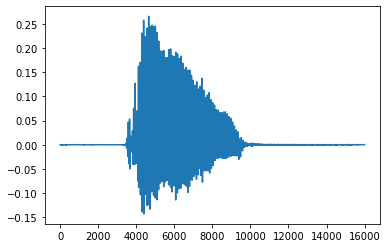

In [22]:
plt.plot(audios[4])

In [27]:
audios.shape

(32, 16000)

In [8]:
from tensorflow.keras.models import Model, load_model

from kapre.time_frequency import Melspectrogram, Spectrogram

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

from tensorflow.keras import layers as Layers
from tensorflow.keras import backend as K


In [50]:
from kapre.utils import Normalization2D

In [125]:
#self-attention LSTM
#nCategs=36
sr=16000
iLen=16000
#from keras import layers as L

# ### Model z atencja
# if modelType != "model-attRNN":
#     model = AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)
# else:
# ### Model bez atencji
#     model = RNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)

### My Model
model = Sequential()
model.add(Layers.Reshape((1, -1)))
model.add(Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
               padding='same', sr=sr, n_mels=80,
               fmin=40.0, fmax=sr / 2, power_melgram=1.0,
               return_decibel_melgram=True, trainable_fb=False,
               trainable_kernel=False,
               name='mel_stft'))
model.add(Normalization2D(int_axis=0))
model.add(Layers.Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim'))
model.add(Layers.LSTM(64, return_sequences=True))
model.add(Layers.LSTM(64, return_sequences=True))
model.add(Layers.LSTM(64, return_sequences=True))
model.add(Layers.LSTM(64, return_sequences=True))
model.add(Layers.Flatten())
model.add(Layers.Dense(64, activation='relu'))
model.add(Layers.Dense(32, activation='relu'))
model.add(Layers.Dense(nCategs, activation='softmax'))

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
# model.summary()

In [86]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [11]:
#self-attention LSTM
#nCategs=36
#sr=16000
#iLen=16000
#from keras import layers as L

### Model z atencja
if modelType != "model-attRNN":
    model = AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)
else:
### Model bez atencji
    model = RNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 1, None)      0           input[0][0]                      
__________________________________________________________________________________________________
mel_stft (Melspectrogram)       (None, 80, None, 1)  1091664     reshape_3[0][0]                  
__________________________________________________________________________________________________
mel_stft_norm (Normalization2D) (None, 80, None, 1)  0           mel_stft[0][0]                   
_______________________________________________________________________________________

In [32]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [126]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint(modelType + ".h5", monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results = model.fit(trainGen, validation_data=valGen, epochs=60, use_multiprocessing=False, workers=4, verbose=2,
                    callbacks=[earlystopper, checkpointer, lrate])

model.save(modelType + ".h5")

Changing learning rate to 0.001
Epoch 1/60

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.51929, saving model to my-model-DeepLSTM.h5
2651/2651 - 247s - loss: 2.1699 - sparse_categorical_accuracy: 0.3708 - val_loss: 1.5776 - val_sparse_categorical_accuracy: 0.5193
Changing learning rate to 0.001
Epoch 2/60

Epoch 00002: val_sparse_categorical_accuracy improved from 0.51929 to 0.59918, saving model to my-model-DeepLSTM.h5
2651/2651 - 257s - loss: 1.4836 - sparse_categorical_accuracy: 0.5566 - val_loss: 1.3134 - val_sparse_categorical_accuracy: 0.5992
Changing learning rate to 0.001
Epoch 3/60

Epoch 00003: val_sparse_categorical_accuracy improved from 0.59918 to 0.64680, saving model to my-model-DeepLSTM.h5
2651/2651 - 257s - loss: 1.2890 - sparse_categorical_accuracy: 0.6110 - val_loss: 1.1507 - val_sparse_categorical_accuracy: 0.6468
Changing learning rate to 0.001
Epoch 4/60

Epoch 00004: val_sparse_categorical_accuracy improved from 0.64680 to 0.66992, saving 

Changing learning rate to 0.00016000000000000004
Epoch 31/60

Epoch 00031: val_sparse_categorical_accuracy did not improve from 0.77864
2651/2651 - 255s - loss: 0.3552 - sparse_categorical_accuracy: 0.8893 - val_loss: 0.8555 - val_sparse_categorical_accuracy: 0.7726
Changing learning rate to 0.00016000000000000004
Epoch 32/60

Epoch 00032: val_sparse_categorical_accuracy did not improve from 0.77864
2651/2651 - 242s - loss: 0.3293 - sparse_categorical_accuracy: 0.8986 - val_loss: 0.8835 - val_sparse_categorical_accuracy: 0.7747
Changing learning rate to 0.00016000000000000004
Epoch 33/60

Epoch 00033: val_sparse_categorical_accuracy did not improve from 0.77864
2651/2651 - 235s - loss: 0.3171 - sparse_categorical_accuracy: 0.9018 - val_loss: 0.8986 - val_sparse_categorical_accuracy: 0.7733
Changing learning rate to 0.00016000000000000004
Epoch 34/60

Epoch 00034: val_sparse_categorical_accuracy did not improve from 0.77864
2651/2651 - 238s - loss: 0.3054 - sparse_categorical_accuracy: 

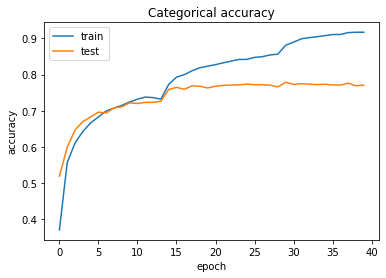

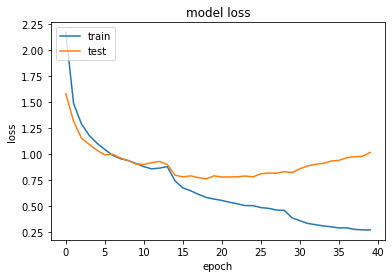

In [127]:
# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# load best model according to cross-validation - model-attRNN
# model = load_model(modelType + ".h5", custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })
model.load_weights(modelType + ".h5")

In [16]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [19]:
x_test.shape

(11005, 16000)

In [128]:
valEval = model.evaluate(valGen, use_multiprocessing=False, workers=4,verbose=0)
trainEval = model.evaluate(trainGen, use_multiprocessing=False, workers=4,verbose=0)
testEval = model.evaluate(x_test, y_test, verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model.metrics_names, trainEval, valEval, testEval) )

Evaluation scores: 
Metrics: ['loss', 'sparse_categorical_accuracy'] 
Train: [0.33735015988349915, 0.8980337381362915] 
Validation: [0.8171331286430359, 0.777532160282135] 
Test: [0.93300861120224, 0.7571104168891907]


In [ ]:
#35word, v2
classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six', 
           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
           'visual', 'wow']

In [9]:
import pandas as pd
import kapre
from kapre.time_frequency import Melspectrogram
from kapre.utils import Normalization2D
[tf.__version__, kapre.__version__, pd.__version__, librosa.__version__]

['2.3.4', '0.2.0', '1.3.5', '0.9.1']

# Save model to .pb

In [10]:
#model = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)
#model.load_weights(modelType + ".h5")

model = load_model(modelType + ".h5", custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })

In [81]:
tf.saved_model.save(model, modelType + "/1/")


INFO:tensorflow:Assets written to: my-model-simpleLSTM/1/assets
